# **Exercício Prático 02 - Viés-Variância em Regressão Polinomial**
## Aprendizado de Máquina A
### **Professor(es):** Gisele Lobo Pappa e Lourenço Ribeiro Grossi Araújo
### **Aluno:** Bernardo Reis de Almeida

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(24)  # Reproducibility

#### **Leitura dos dados**

In [2]:
# Reading all the data from csv
data = pd.read_csv("bias_variance_data.csv")

In [3]:
data.describe()

,scenario_id,replicate,n_train,noise_sigma,seed,x,y_true,epsilon,y,f_alpha,f_period,x_min,x_max
count,43380.000000,43380.000000,43380.000000,43380.000000,4.338000e+04,43380.000000,43380.000000,43380.000000,43380.000000,4.338000e+04,43380.0,43380.0,43380.0
mean,5.244813,9.500000,209.709544,0.350000,1.051697e+09,1.497799,0.049570,-0.002839,0.046731,8.000000e-01,1.0,0.0,3.0
std,2.421597,5.766348,131.600046,0.324041,5.652734e+08,0.869809,0.315389,0.365630,0.484177,2.220472e-16,0.0,0.0,0.0
min,0.000000,0.000000,20.000000,0.050000,1.078538e+07,0.000000,-0.553266,-2.959822,-3.305625,8.000000e-01,1.0,0.0,3.0
25%,3.000000,4.750000,80.000000,0.050000,5.520626e+08,0.745080,-0.120319,-0.021976,-0.187309,8.000000e-01,1.0,0.0,3.0
50%,6.000000,9.500000,320.000000,0.200000,1.064359e+09,1.500000,0.000000,0.000000,0.008566,8.000000e-01,1.0,0.0,3.0
75%,7.000000,14.250000,320.000000,0.800000,1.488660e+09,2.250000,0.195641,0.020277,0.274739,8.000000e-01,1.0,0.0,3.0
max,8.000000,19.000000,320.000000,0.800000,2.123951e+09,3.000000,0.825376,2.875059,2.936438,8.000000e-01,1.0,0.0,3.0


In [4]:
data.head()

,split,scenario_id,scenario_label,replicate,n_train,noise_sigma,seed,x,y_true,epsilon,y,f_alpha,f_period,x_min,x_max
0,test,0,n20_sigma0.05,0,20,0.05,1501552845,0.00,0.000000,0.0,0.000000,0.8,1.0,0.0,3.0
1,test,0,n20_sigma0.05,0,20,0.05,1501552845,0.03,0.182938,0.0,0.182938,0.8,1.0,0.0,3.0
2,test,0,n20_sigma0.05,0,20,0.05,1501552845,0.06,0.350872,0.0,0.350872,0.8,1.0,0.0,3.0
3,test,0,n20_sigma0.05,0,20,0.05,1501552845,0.09,0.498603,0.0,0.498603,0.8,1.0,0.0,3.0
4,test,0,n20_sigma0.05,0,20,0.05,1501552845,0.12,0.621886,0.0,0.621886,0.8,1.0,0.0,3.0


In [5]:
# Sorts the data by x
data = data.sort_values("x")

#### **Definições**

In [6]:
def get_train_dataset(data, n_train, noise_sigma, replicate):
    mask = (
        (data["n_train"] == n_train)
        & (data["noise_sigma"] == noise_sigma)
        & (data["replicate"] == replicate)
        & (data["split"] == "train")
    )
    return data.loc[mask].copy()


def get_test_dataset(data, n_train, noise_sigma):
    mask = (
        (data["n_train"] == n_train)
        & (data["noise_sigma"] == noise_sigma)
        & (data["replicate"] == 0)
        & (data["split"] == "test")
    )
    return data.loc[mask].copy()


def filter_data(data, n_train, noise_sigma, replicate=None, degree=None, split=None):
    mask = (data["n_train"] == n_train) & (data["noise_sigma"] == noise_sigma)

    if (replicate != None) and ("replicate" in data.columns):
        mask = mask & (data["replicate"] == replicate)

    if (degree != None) and ("degree" in data.columns):
        mask = mask & (data["degree"] == degree)

    if (split != None) and ("split" in data.columns):
        mask = mask & (data["split"] == split)

    return data.loc[mask].copy()


class OLS:
    def __init__(self, degree: int = 1):
        self.degree = degree

        self.coef = None
        self.residuals = None
        self.rank = None
        self.singular_values = None

    def build_matrix(self, X):
        X_ = np.ones((X.shape[0], 1))
        for i in range(1, self.degree + 1):
            X_ = np.concat([X_, np.pow(X, i)], axis=1)
        return X_

    def fit(self, X, y):
        X_ = self.build_matrix(X)
        self.coef, self.residuals, self.rank, self.singular_values = np.linalg.lstsq(
            X_, y
        )

    def predict(self, X):
        X_ = self.build_matrix(X)
        return X_ @ self.coef

    def mse(self, X, y):
        X_ = self.build_matrix(X)
        y_ = self.predict(X_)
        return np.mean(np.pow(y - y_, 2))

In [7]:
# Scenario and model parameters
n_trains = [20, 80, 320]
noise_sigmas = [0.05, 0.2, 0.8]
replicates = range(20)
degrees = range(16)

#### **Parte A:** Ajuste por OLS em cada réplica

In [8]:
# Dataframe to store results
dataA = pd.DataFrame(
    columns=["n_train", "noise_sigma", "replicate", "degree", "x", "y", "y_"]
)

for n_train, noise_sigma, replicate in itertools.product(
    n_trains, noise_sigmas, replicates
):
    # Prepares the train data
    train_data = filter_data(data, n_train, noise_sigma, replicate, split="train")
    X_train = train_data["x"].to_numpy().reshape((-1, 1))
    y_train = train_data["y"].to_numpy().reshape((-1, 1))

    # Prepares the test data
    test_data = filter_data(data, n_train, noise_sigma, 0, split="test")
    X_test = test_data["x"].to_numpy().reshape((-1, 1))
    y_test = test_data["y_true"].to_numpy().reshape((-1, 1))

    for degree in degrees:
        # Fits the model
        model = OLS(degree=degree)
        model.fit(X_train, y_train)

        # Predicts using test data
        y_ = model.predict(X_test)

        # Updates results
        for i in range(X_test.shape[0]):
            dataA.loc[-1] = [
                n_train,
                noise_sigma,
                replicate,
                degree,
                X_test[i][0],
                y_test[i][0],
                y_[i][0],
            ]
            dataA.index = dataA.index + 1

# Maintains order by x
dataA = dataA.sort_values("x")

In [9]:
dataA.describe()

,n_train,noise_sigma,replicate,degree,x,y,y_
count,290880.000000,290880.000000,290880.000000,290880.00000,290880.000000,290880.000000,2.908800e+05
mean,140.000000,0.350000,9.500000,7.50000,1.500000,0.046858,-5.969622e+02
std,129.615037,0.324038,5.766291,4.60978,0.874644,0.313782,1.734256e+05
min,20.000000,0.050000,0.000000,0.00000,0.000000,-0.552185,-6.410210e+07
25%,20.000000,0.050000,4.750000,3.75000,0.750000,-0.115377,-1.253031e-01
50%,80.000000,0.200000,9.500000,7.50000,1.500000,0.000000,1.733449e-02
75%,320.000000,0.800000,14.250000,11.25000,2.250000,0.182938,1.787336e-01
max,320.000000,0.800000,19.000000,15.00000,3.000000,0.823678,9.955046e+06


In [10]:
dataA.head()

,n_train,noise_sigma,replicate,degree,x,y,y_
123421,80.0,0.80,3.0,10.0,0.0,0.0,0.102026
37470,320.0,0.20,16.0,13.0,0.0,0.0,0.169419
290778,20.0,0.05,0.0,1.0,0.0,0.0,-0.157525
16563,320.0,0.80,9.0,12.0,0.0,0.0,-1.676948
290879,20.0,0.05,0.0,0.0,0.0,0.0,-0.074348


#### **Parte B:** Estimativa empírica de viés e variância

In [11]:
# Dataframe to store results
dataB = pd.DataFrame(
    columns=[
        "n_train",
        "noise_sigma",
        "degree",
        "x",
        "y",
        "y_mean",
        "bias",
        "var",
        "mse_nl",
        "mse",
    ]
)

for n_train, noise_sigma, degree in itertools.product(n_trains, noise_sigmas, degrees):
    # Prepares the input data
    input_data = filter_data(dataA, n_train, noise_sigma, degree=degree)

    # Prepares the test data
    test_data = filter_data(data, n_train, noise_sigma, 0, split="test")
    X_test = test_data["x"].to_numpy().reshape((-1, 1))
    y_test = test_data["y_true"].to_numpy().reshape((-1, 1))

    # Takes the mean of the predictions
    y_mean = np.zeros((y_test.shape[0], 1))
    for r in replicates:
        y_ = (
            input_data[input_data["replicate"] == r]["y_"]
            .to_numpy(copy=True)
            .reshape((-1, 1))
        )
        y_mean += y_
    y_mean /= len(replicates)

    # Computes bias
    bias = y_mean - y_test

    # Computes variance
    var = np.zeros((y_test.shape[0], 1))
    for r in replicates:
        y_ = (
            input_data[input_data["replicate"] == r]["y_"]
            .to_numpy(copy=True)
            .reshape((-1, 1))
        )
        var += np.pow(y_ - y_mean, 2)
    var /= len(replicates) - 1

    # Computes mse_nl (noiseless)
    mse_nl = np.pow(bias, 2) + var

    # Computes mse (w/ noise)
    mse = np.pow(bias, 2) + var + np.pow(noise_sigma, 2)

    # Updates results
    for i in range(X_test.shape[0]):
        dataB.loc[-1] = [
            n_train,
            noise_sigma,
            degree,
            X_test[i][0],
            y_test[i][0],
            y_mean[i][0],
            bias[i][0],
            var[i][0],
            mse_nl[i][0],
            mse[i][0],
        ]
        dataB.index = dataB.index + 1

# Maintains order by x
dataB = dataB.sort_values("x")

In [12]:
dataB.describe()

,n_train,noise_sigma,degree,x,y,y_mean,bias,var,mse_nl,mse
count,14544.00000,14544.000000,14544.000000,14544.000000,14544.000000,1.454400e+04,1.454400e+04,1.454400e+04,1.454400e+04,1.454400e+04
mean,140.00000,0.350000,7.500000,1.500000,0.046858,-5.969622e+02,-5.970091e+02,3.007394e+10,3.158040e+10,3.158040e+10
std,129.61927,0.324048,4.609931,0.874673,0.313793,3.880988e+04,3.880988e+04,2.003237e+12,2.104156e+12,2.104156e+12
min,20.00000,0.050000,0.000000,0.000000,-0.552185,-3.221329e+06,-3.221329e+06,2.334038e-05,2.637054e-05,2.526371e-03
25%,20.00000,0.050000,3.750000,0.750000,-0.115377,-9.829325e-02,-9.313058e-02,1.536685e-03,7.911274e-03,4.158864e-02
50%,80.00000,0.200000,7.500000,1.500000,0.000000,1.915455e-02,2.506618e-05,1.033945e-02,3.761525e-02,1.124843e-01
75%,320.00000,0.800000,11.250000,2.250000,0.182938,1.580361e-01,9.303270e-02,6.451361e-02,1.603015e-01,7.150852e-01
max,320.00000,0.800000,15.000000,3.000000,0.823678,4.937512e+05,4.937512e+05,2.053485e+14,2.157255e+14,2.157255e+14


In [13]:
dataB.head()

,n_train,noise_sigma,degree,x,y,y_mean,bias,var,mse_nl,mse
12927,20.0,0.20,0.0,0.0,0.0,0.033785,0.033785,0.008511,0.009652,0.049652
11917,20.0,0.20,10.0,0.0,0.0,-9.092828,-9.092828,1819.669918,1902.349432,1902.389432
5352,80.0,0.80,11.0,0.0,0.0,0.414136,0.414136,11.681718,11.853227,12.493227
1211,320.0,0.80,4.0,0.0,0.0,0.883366,0.883366,0.090542,0.870878,1.510878
9594,80.0,0.05,1.0,0.0,0.0,0.196002,0.196002,0.010026,0.048443,0.050943


#### **Parte C:** Métricas agregadas por grau

In [14]:
# Dataframe to store results
dataC = pd.DataFrame(
    columns=[
        "n_train",
        "noise_sigma",
        "degree",
        "bias2",
        "var",
        "mse",
    ]
)

for n_train, noise_sigma, degree in itertools.product(n_trains, noise_sigmas, degrees):
    # Prepares the input data
    input_data = filter_data(dataB, n_train, noise_sigma, degree=degree)

    # Prepares the test data
    test_data = filter_data(data, n_train, noise_sigma, 0, split="test")
    X_test = test_data["x"].to_numpy().reshape((-1, 1))
    y_test = test_data["y_true"].to_numpy().reshape((-1, 1))

    # Computes averaged metrics
    bias2_mean = np.mean(np.pow(input_data["bias"].to_numpy(copy=True), 2))
    var_mean = np.mean(input_data["var"].to_numpy(copy=True))
    mse_mean = bias2_mean + var_mean + np.pow(noise_sigma, 2)

    # Updates results
    dataC.loc[-1] = [
        n_train,
        noise_sigma,
        degree,
        bias2_mean,
        var_mean,
        mse_mean,
    ]
    dataC.index = dataC.index + 1

In [15]:
dataC.describe()

,n_train,noise_sigma,degree,bias2,var,mse
count,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02
mean,140.000000,0.350000,7.500000,1.506460e+09,3.007394e+10,3.158040e+10
std,130.067223,0.325168,4.625862,1.761685e+10,3.518627e+11,3.694796e+11
min,20.000000,0.050000,0.000000,9.230968e-06,1.299713e-04,2.653326e-03
25%,20.000000,0.050000,3.750000,1.873722e-02,2.643902e-03,8.110790e-02
50%,80.000000,0.200000,7.500000,7.395447e-02,2.542352e-02,3.660827e-01
75%,320.000000,0.800000,11.250000,9.915975e-02,6.478488e-01,1.065771e+00
max,320.000000,0.800000,15.000000,2.113711e+11,4.221766e+12,4.433137e+12


In [16]:
dataC.head()

,n_train,noise_sigma,degree,bias2,var,mse
143,20.0,0.05,0.0,0.098460,0.004334,0.105294
142,20.0,0.05,1.0,0.089620,0.009442,0.101562
141,20.0,0.05,2.0,0.082116,0.015282,0.099898
140,20.0,0.05,3.0,0.072245,0.026833,0.101578
139,20.0,0.05,4.0,0.075513,0.072613,0.150627


##### **Tabelas**

In [17]:
# Tables with results
mask = (dataC["degree"] == 1) | (dataC["degree"] == 5) | (dataC["degree"] == 9) | (dataC["degree"] == 15)
results = dataC.loc[mask].copy()
for n_train, noise_sigma in itertools.product(n_trains, noise_sigmas):
    scenario = filter_data(results, n_train, noise_sigma)
    display(scenario.reset_index(drop=True))

,n_train,noise_sigma,degree,bias2,var,mse
0,20.0,0.05,1.0,0.089620,9.441877e-03,1.015617e-01
1,20.0,0.05,5.0,0.137766,1.975838e-01,3.378499e-01
2,20.0,0.05,9.0,0.996407,7.360649e+00,8.359556e+00
3,20.0,0.05,15.0,697018.540214,1.555872e+07,1.625574e+07


,n_train,noise_sigma,degree,bias2,var,mse
0,20.0,0.2,1.0,0.089816,0.013850,0.143666
1,20.0,0.2,5.0,0.151387,0.202929,0.394315
2,20.0,0.2,9.0,0.338257,8.765974,9.144232
3,20.0,0.2,15.0,2985.095341,66749.271405,69734.406746


,n_train,noise_sigma,degree,bias2,var,mse
0,20.0,0.8,1.0,9.279585e-02,1.041280e-01,8.369238e-01
1,20.0,0.8,5.0,1.786848e-01,8.465562e-01,1.665241e+00
2,20.0,0.8,9.0,3.791803e+01,3.612899e+02,3.998479e+02
3,20.0,0.8,15.0,2.113711e+11,4.221766e+12,4.433137e+12


,n_train,noise_sigma,degree,bias2,var,mse
0,80.0,0.05,1.0,0.089622,0.002731,0.094853
1,80.0,0.05,5.0,0.070561,0.007350,0.080411
2,80.0,0.05,9.0,0.005056,0.003182,0.010738
3,80.0,0.05,15.0,0.000077,0.005896,0.008473


,n_train,noise_sigma,degree,bias2,var,mse
0,80.0,0.2,1.0,0.089741,0.004313,0.134053
1,80.0,0.2,5.0,0.075265,0.034084,0.149349
2,80.0,0.2,9.0,0.005659,0.018921,0.064580
3,80.0,0.2,15.0,0.017483,0.745292,0.802775


,n_train,noise_sigma,degree,bias2,var,mse
0,80.0,0.8,1.0,0.090867,0.020553,0.751420
1,80.0,0.8,5.0,0.086437,0.086404,0.812841
2,80.0,0.8,9.0,0.011779,0.144649,0.796428
3,80.0,0.8,15.0,0.350572,5.651409,6.641981


,n_train,noise_sigma,degree,bias2,var,mse
0,320.0,0.05,1.0,0.089810,0.000755,0.093066
1,320.0,0.05,5.0,0.070013,0.002136,0.074649
2,320.0,0.05,9.0,0.003706,0.000258,0.006464
3,320.0,0.05,15.0,0.000013,0.000180,0.002693


,n_train,noise_sigma,degree,bias2,var,mse
0,320.0,0.2,1.0,0.089654,0.000795,0.130449
1,320.0,0.2,5.0,0.069909,0.002997,0.112906
2,320.0,0.2,9.0,0.003777,0.001620,0.045397
3,320.0,0.2,15.0,0.000042,0.002161,0.042202


,n_train,noise_sigma,degree,bias2,var,mse
0,320.0,0.8,1.0,0.089904,0.004891,0.734795
1,320.0,0.8,5.0,0.070508,0.017908,0.728415
2,320.0,0.8,9.0,0.004435,0.028626,0.673061
3,320.0,0.8,15.0,0.001658,0.051411,0.693069


#### **Parte D:** Visualizações e discussão

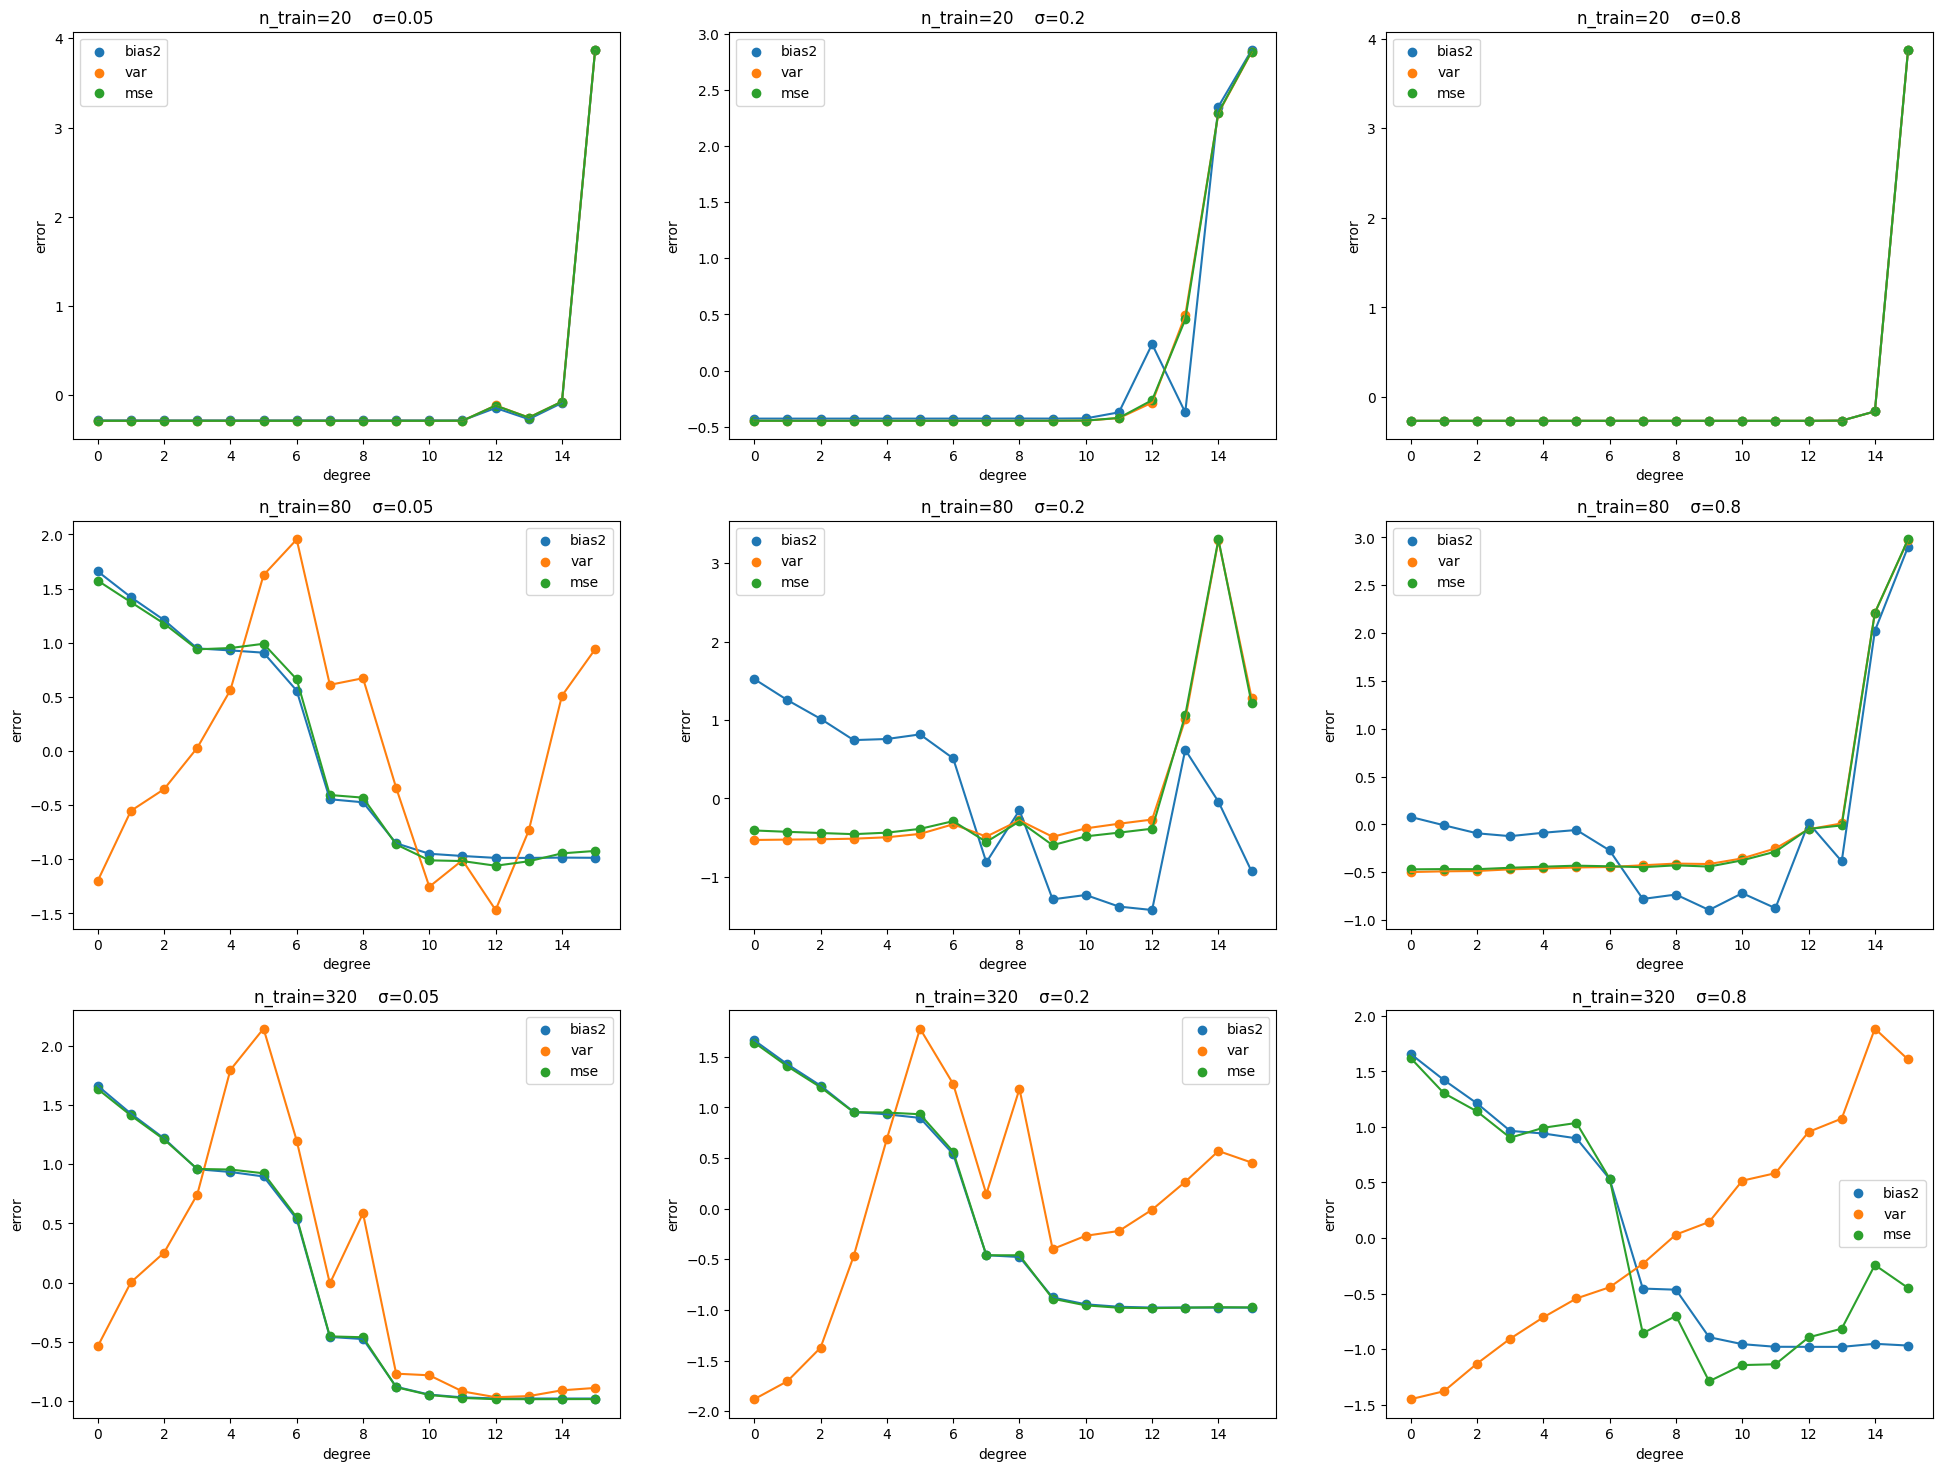

In [18]:
# Plotting settings
fig, axs = plt.subplots(len(n_trains), len(noise_sigmas))
fig.set_size_inches(24, 18)
plot_index = 0

for n_train, noise_sigma in itertools.product(n_trains, noise_sigmas):
    # Filters out the scenario
    scenario = filter_data(dataC, n_train, noise_sigma)
    scenario = scenario.sort_values("degree")  # Sorts by degree to facilitate plotting

    # Filters out relevant variables
    bias2_mean = scenario["bias2"].to_numpy(copy=True)
    var_mean = scenario["var"].to_numpy(copy=True)
    mse_mean = scenario["mse"].to_numpy(copy=True)
    scenario_degrees = scenario["degree"].to_numpy(copy=True)

    # Normalizes them
    bias2_mean = (bias2_mean - np.mean(bias2_mean)) / np.std(bias2_mean)
    var_mean = (var_mean - np.mean(var_mean)) / np.std(var_mean)
    mse_mean = (mse_mean - np.mean(mse_mean)) / np.std(mse_mean)

    # Plot the scenario graph
    i = int(plot_index / len(noise_sigmas))
    j = plot_index % len(noise_sigmas)

    axs[i][j].scatter(scenario_degrees, bias2_mean, label="bias2")
    axs[i][j].plot(scenario_degrees, bias2_mean)

    axs[i][j].scatter(scenario_degrees, var_mean, label="var")
    axs[i][j].plot(scenario_degrees, var_mean)

    axs[i][j].scatter(scenario_degrees, mse_mean, label="mse")
    axs[i][j].plot(scenario_degrees, mse_mean)

    axs[i][j].set_title(f"n_train={n_train}    σ={noise_sigma}")
    axs[i][j].set_xlabel(f"degree")
    axs[i][j].set_ylabel(f"error")
    axs[i][j].legend()

    plot_index += 1

# Shows the graph
plt.show()
plt.close()

***O viés, a variância e o erro foram z-normalizados para que os gráficos fossem capazes de expressar melhor suas tendências.***

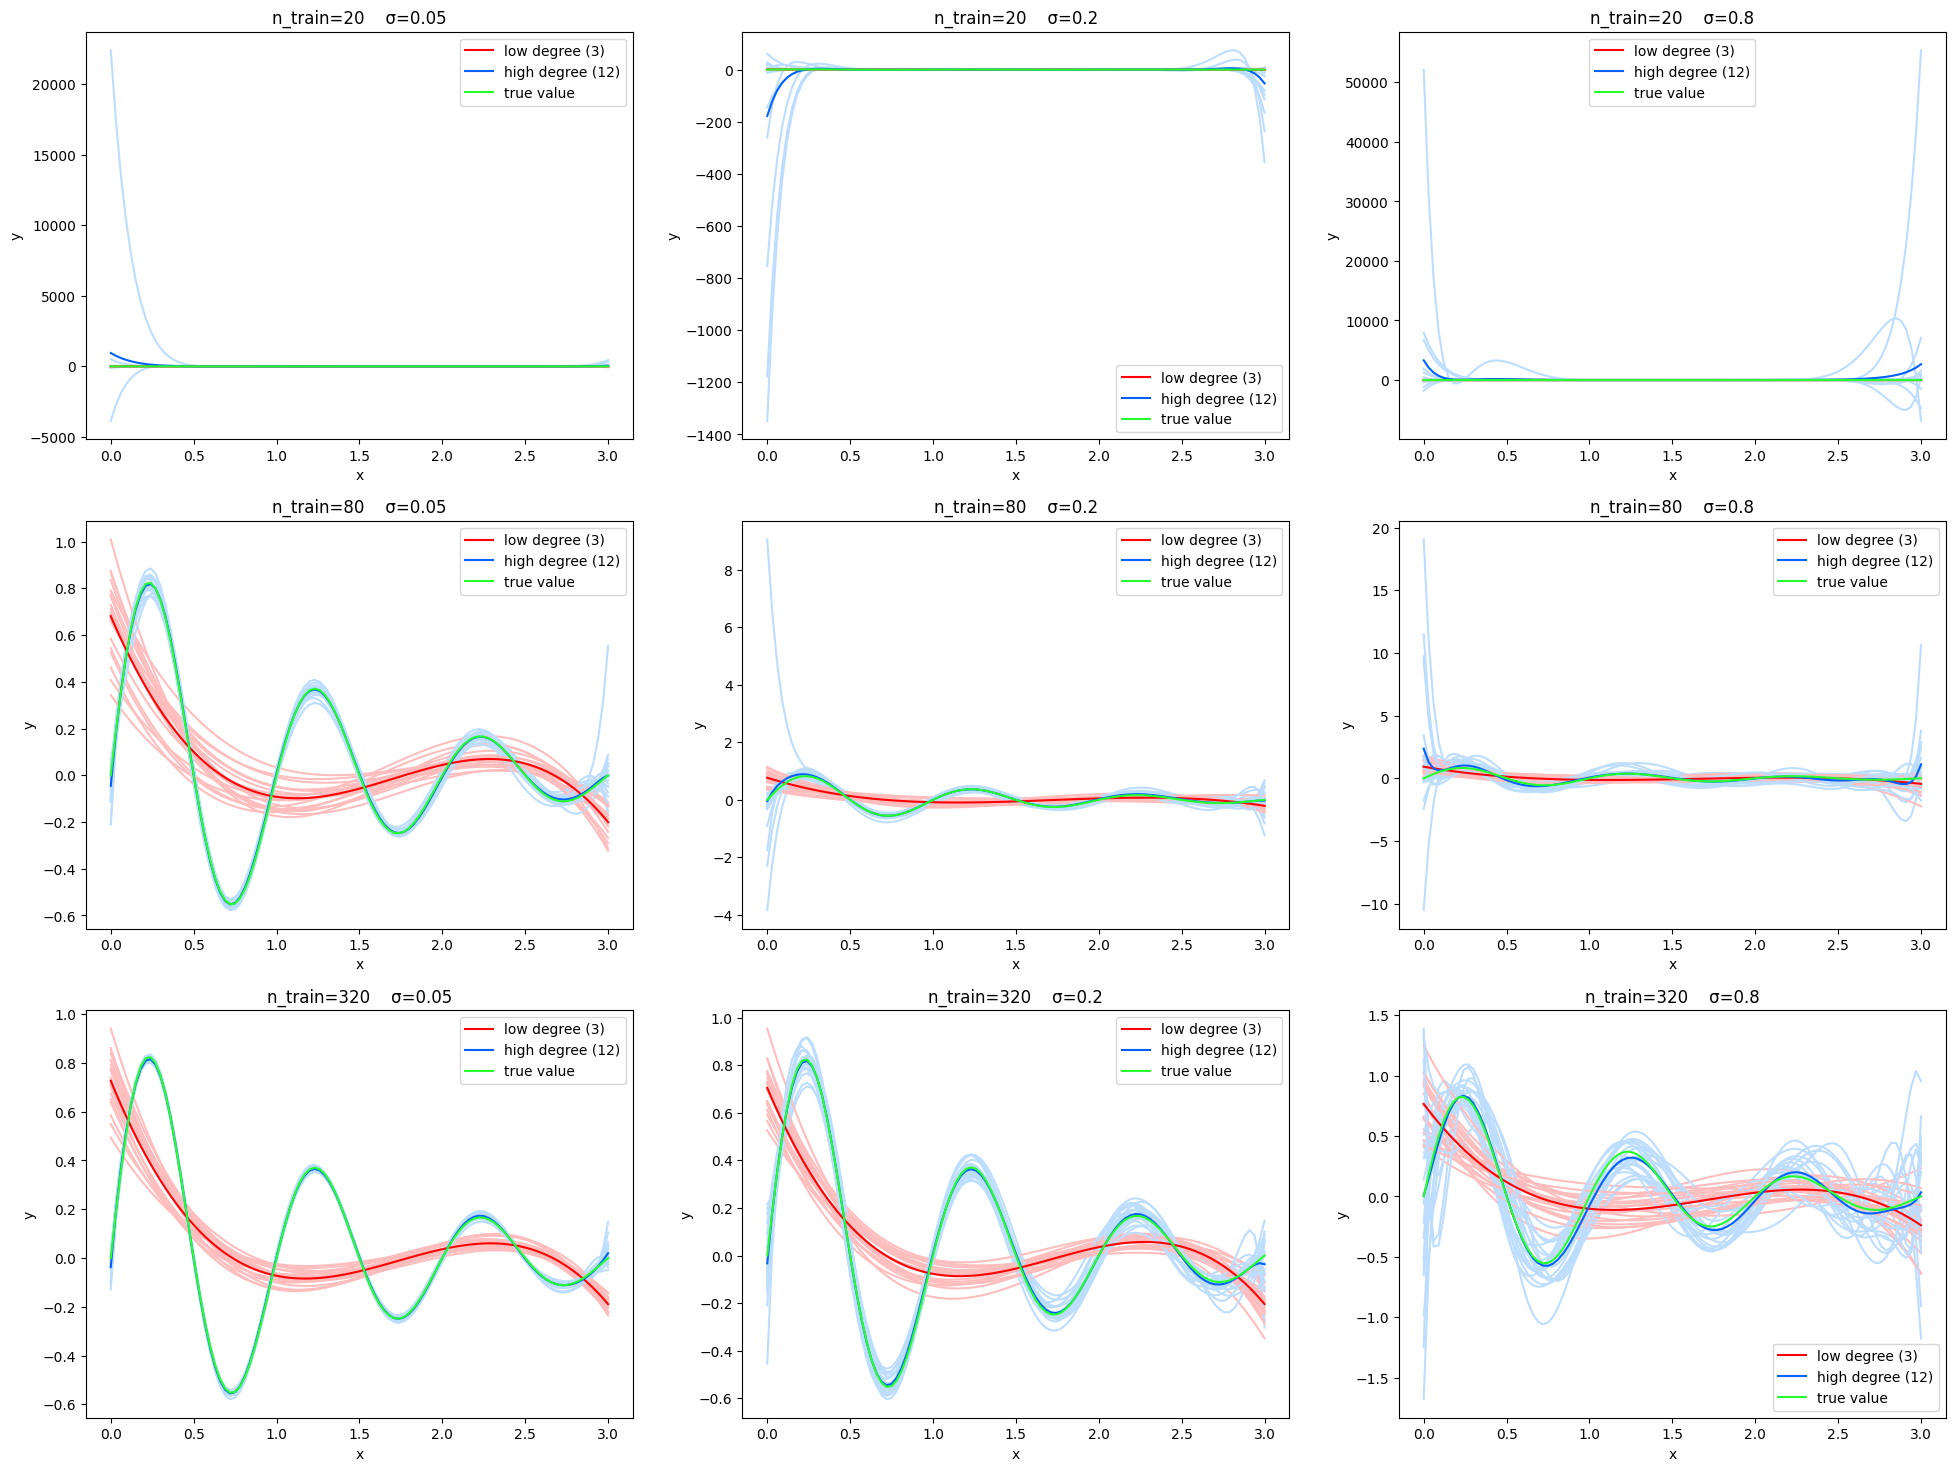

In [19]:
# Plotting settings
fig, axs = plt.subplots(len(n_trains), len(noise_sigmas))
fig.set_size_inches(24, 18)
plot_index = 0

# Parameters
low_degree = 3
high_degree = 12

for n_train, noise_sigma in itertools.product(n_trains, noise_sigmas):
    # Filters out the samples (low degree)
    l_samples = filter_data(dataA, n_train, noise_sigma, degree=low_degree)
    l_samples = l_samples.sort_values("x")  # Sorts by x to facilitate plotting

    # Filters out the samples (high degree)
    h_samples = filter_data(dataA, n_train, noise_sigma, degree=high_degree)
    h_samples = h_samples.sort_values("x")  # Sorts by x to facilitate plotting

    # Filters out the mean (low degree)
    l_mean = filter_data(dataB, n_train, noise_sigma, degree=low_degree)
    l_mean = l_mean.sort_values("x")  # Sorts by x to facilitate plotting

    # Filters out the mean (high degree)
    h_mean = filter_data(dataB, n_train, noise_sigma, degree=high_degree)
    h_mean = h_mean.sort_values("x")  # Sorts by x to facilitate plotting

    # Prepares the test data (already sorted by x)
    test_data = filter_data(data, n_train, noise_sigma, 0, split="test")

    # Chooses the correct graph
    i = int(plot_index / len(noise_sigmas))
    j = plot_index % len(noise_sigmas)

    # Plots the results of each sample (replicate)
    for r in replicates:
        # (low degree)
        X = l_samples[l_samples["replicate"] == r]["x"].to_numpy(copy=True)
        y_ = l_samples[l_samples["replicate"] == r]["y_"].to_numpy(copy=True)
        axs[i][j].plot(X, y_, color="#ffbdbd")

        # (high degree)
        X = h_samples[h_samples["replicate"] == r]["x"].to_numpy(copy=True)
        y_ = h_samples[h_samples["replicate"] == r]["y_"].to_numpy(copy=True)
        axs[i][j].plot(X, y_, color="#bdddff")

    # Plots the mean results of the samples (replicates) (low degree)
    X = l_mean["x"].to_numpy(copy=True)
    y_mean = l_mean["y_mean"].to_numpy(copy=True)
    axs[i][j].plot(X, y_mean, label=f"low degree ({low_degree})", color="#fc0303")

    # Plots the mean results of the samples (replicates) (high degree)
    X = h_mean["x"].to_numpy(copy=True)
    y_mean = h_mean["y_mean"].to_numpy(copy=True)
    axs[i][j].plot(X, y_mean, label=f"high degree ({high_degree})", color="#0362fc")

    # Plots the real curve (the test curve)
    X_test = test_data["x"].to_numpy().reshape((-1, 1))
    y_test = test_data["y_true"].to_numpy().reshape((-1, 1))
    axs[i][j].plot(X_test, y_test, label="true value", color="#26ff2d")

    # Label settings
    axs[i][j].set_title(f"n_train={n_train}    σ={noise_sigma}")
    axs[i][j].set_xlabel("x")
    axs[i][j].set_ylabel("y")
    axs[i][j].legend()

    plot_index += 1

# Shows the graph
plt.show()
plt.close()

##### **Discussão**

Em teoria, um aumento na complexidade do modelo - neste caso, um aumento no grau do polinômio sendo ajustado aos dados - deve levar a uma redução no viés e a um aumento na variância. Isto, pois "complexidade" pode ser pensada como o horizonte de funções que são possíveis de serem representadas pelo modelo, ou seja, quanto maior esse horizonte, maior a probabilidade de a função manifestada pelos dados ser capturada precisamente por ele - redução do viés -, mas, ao mesmo tempo, detalhes de amostras particulares também serão melhor capturados - aumento da variância. Este comportamento pode ser claramente visto no último gráfico da primeira figura, referente ao cenário com 320 amostras de treinamento e ruído amostral de 0.8. Quanto maior o grau do polinômio, maior a variância (a qual começa baixa) e menor o viés (o qual começa alto), enquanto o erro médio mínimo ocorre em um ponto intermediário no qual essas duas grandezas são melhor equilibradas (~9 graus). Entretanto, nos casos em que existem poucos dados de treinamento (primeiras duas linhas da figura), pode-se pensar que tanto o viés, quanto a variância, serão altos. No caso do viés, mesmo que o modelo se ajuste perfeitamente a tais amostras, a função resultante ainda estará longe da função real, já que, por sua pequena quantidade, elas não capturam bem a tendência real dos dados. Já para a variância, uma lógica análoga se aplica, no sentido de que a variabilidade das tendências capturadas por poucos pontos tende a ser maior do que aquelas capturadas por um volume grande de pontos extraídos de uma mesma distribuição. Ainda, nos casos em que o ruído amostral é pequeno (primeiras duas colunas), a variabilidade também será pequena de maneira geral, já que, por construção, as amostras aproximarão bem a distribuição real dos dados e serão pouco distintas entre si (o que é, em parte, uma consequência do ruído amostral), principalmente quando forem grandes.

O nível de ruído amostral dos dados diz respeito à magnitude da variância do erro que leva o valor de amostras a desviar de sua "distribuição verdadeira", assumindo a integridade da relação $y=f(x)+e$. Retomando a fórmula para cálculo do MSE, pode-se observar que há um impacto direto dessa magnitude em seu valor, o que é esperado, dado que um maior ruído, de certa forma, distancia a distribuição da amostra da distribuição real, sendo que aquela é aquilo efetivamente aproximado pelo modelo, minimizando sua precisão quando aplicado sobre dados provenientes desta. De fato, é possível observar nas tabelas da Parte C que, em todos os casos, quanto maior o ruído amostral, maior é o valor do MSE médio dos modelos quando aplicados sobre os dados de teste. Além disso, também é notável na última linha da segunda figura que o aumento do ruído leva a um aumento da variabilidade do ajuste do modelo a diferentes amostras, dado que elas serão mais diferentes entre si. No caso de ruído máximo, como é possível observar no último gráfico da primeira figura, observa-se a relevância de se encontrar uma complexidade (um grau de polinômio) que equilibre o viés (ajuste aos dados) e a variância (sensibilidade do modelo a diferentes amostras), levando ao erro médio mínimo. Para um nível de ruído mínimo, entretanto, como no primeiro gráfico da última linha, um modelo muito complexo (com um grau muito elevado) ainda leva a bons resultados, já que a amostra em si captura bem, em grande medida, a distribuição verdadeira dos dados, de modo que a variabilidade seja baixa e a acurácia seja razoável mesmo para dados não vistos. Ou seja, pode-se dizer que a utilidade marginal de aumentar a complexidade (grau $d$ do polinômio) é maior, já que a variância não é mais um problema tão relevante e um sobreajuste aos dados de treino aproxima bem sua distribuição real, isto é, o valor de futuras novas instâncias ainda não vistas, principalmente quando se possui uma amostra grande.

O tamanho do conjunto de dados de treino tem um impacto direto no balanço entre viés e variância durante o ajuste de um modelo. Em particular, quanto maiores forem as amostras, mais exemplos da distribuição-alvo o modelo terá, o que permite a aproximar de uma maneira melhor. Em mais detalhes, o viés será reduzido, pois as amostras irão capturar melhor a tendência (a função) real dos dados, assim como a variância também será menor, pois muitas instâncias tendem a cancelar os erros amostrais umas das outras. No outro sentido, quanto menores forem as amostras, menor será a representatividade delas com relação a sua distribuição, assim como mais sujeito o modelo estará a variabilidades do processo de amostragem - de maneira geral, maior será o viés e a variância. Por exemplo, mesmo provenientes da mesma distribuição, duas amostras pequenas podem estar espacialmente distribuídas de maneiras completamente diferentes. As tabelas da Parte C demonstram claramente esses resultados. Para um valor de ruído fixo - diga-se, 0.8 -, é possível observar como o aumento na quantidade de amostras leva a reduções nas magnitudes médias do viés e da variância para todos os graus de polinômio considerados. Esta natureza também pode ser observada na segunda figura. Para conjuntos de dados de treino pequenos (primeira linha), o modelo teve dificuldades em aproximar principalmente os extremos da função original, provavelmente pois haviam poucas amostras neles. Porém, conforme a quantidade de instâncias de treino vai aumentando (sendo o máximo representado na última linha), o polinômio consegue capturar com mais precisão a distribuição real dos dados. Quando se pensa em modelos mais complexos (no caso, polinômios de grau mais elevado), sujeitos a um sobreajuste aos dados de treino, o problema é apenas intensificado, já que o sobreajuste a uma amostra pequena e pouco representativa está sendo orientado a uma aproximação ruim da distribuição real dos dados, o que pode resultar em um alto viés e em uma alta variância.

A partir da última linha da segunda figura, focando nas curvas para um polinômio de grau baixo, é possível observar com clareza que, para valores baixos de $x$, há um subajuste razoável do modelo aos dados reais, o que é marginalmente minimizado conforme $x$ cresce, mesmo que, no geral, haja um subajuste à amostra de treino como um todo, o que é esperado de um modelo menos complexo. Já para as curvas relativas a um polinômio de grau alto, é possível observar que há um melhor ajuste aos dados, como esperado de um modelo mais complexo. Porém, esse ajuste é melhor e menos variável para valores menores de $x$, enquanto que, conforme $x$ cresce, é possível observar um aumento na variabilidade do modelo, o que é representado por curvas de ajuste a cada uma das réplicas mais diferentes entre si. Em outras palavras, há um sobreajuste nessas regiões de baixo sinal (baixa amplitude dos valores de $y$), o que resulta na maior variância observada. Essas evidências indicam empiricamente que, de fato, a degradação da SNR à medida que $x$ cresce favorece um subajuste em graus baixos e um sobreajuste local em graus altos em regiões de baixo sinal.

#### **Parte E:** Esboço explicativo

*Feito à mão e anexado ao .pdf*